# Создание модели с автоматическими сегментами

# 0. Импорт библиотек

In [130]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')

# 1. Знакомство с данными

### Справочник категорий

In [131]:
# Чтение данных
dim_category = pd.read_csv('data/dim_category.zip')
display(dim_category.head(2))

,КодКатегории,Уровень4
0,EM85913,Стеклоочиститель портативный
1,AM24371,Пылесос строительный


In [132]:
dim_category.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718 entries, 0 to 717
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   КодКатегории  718 non-null    object
 1   Уровень4      718 non-null    object
dtypes: object(2)
memory usage: 11.3+ KB


In [133]:
# Описательная статистика
dim_category.describe()

,КодКатегории,Уровень4
count,718,718
unique,718,718
top,EM85913,Стеклоочиститель портативный
freq,1,1


В справочнике всего 718 уникальных категорий, пропусков нет.

### Приоритеты характеристик

In [134]:
# Чтение данных
site_priorities = pd.read_csv('data/site_priorities.zip')
site_priorities.head(2)

,Категория,ID характеристики,Название характеристики,Приоритет,"Частота использования, %",Количество кликов
0,Электронные книги,1000,Объем встроенной памяти,720,0.0013,80
1,Электронные книги,989,Диагональ дисплея,900,0.2591,15525


In [135]:
site_priorities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27296 entries, 0 to 27295
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Категория                 27296 non-null  object 
 1   ID характеристики         27296 non-null  int64  
 2   Название характеристики   27296 non-null  object 
 3   Приоритет                 27296 non-null  int64  
 4   Частота использования, %  27296 non-null  float64
 5   Количество кликов         27296 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 1.2+ MB


In [136]:
# Описательная статистика
display(site_priorities['Приоритет'].describe())
site_priorities.nunique()

count    27296.000000
mean       825.076568
std         85.131890
min       -140.000000
25%        800.000000
50%        850.000000
75%        880.000000
max        900.000000
Name: Приоритет, dtype: float64

Категория                    2654
ID характеристики           26610
Название характеристики      7942
Приоритет                     105
Частота использования, %     3074
Количество кликов            3604
dtype: int64

1. В справочнике приоритетов 2654 категории, 26610 характеристик, пропусков нет.
2. Диапазон приоритетов от -140 до 900

In [137]:
# Меняю тип данных на строковый
site_priorities['ID характеристики'] = site_priorities['ID характеристики'].astype('str')

### Справочник характеристик товара

In [138]:
# Чтение данных
product_specifications = pd.read_csv('data/product_specifications.zip')
df_0 = product_specifications.copy() # Копия исходных данных
product_specifications.head(2)

,Код,ВидХарактеристики,КодВидаХарактеристики,КодХарактеристики,Характеристика,Значимость
0,5334213,Наличие фильтра от мелких частиц,13494,163267,есть,200
1,5334213,Напряжение питания,1205937,60932058,220-240 В / 50 Гц,110


In [139]:
product_specifications = product_specifications.rename(columns={'Код':'КодТовара'})
product_specifications.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82949 entries, 0 to 82948
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   КодТовара              82949 non-null  int64 
 1   ВидХарактеристики      82949 non-null  object
 2   КодВидаХарактеристики  82949 non-null  int64 
 3   КодХарактеристики      82949 non-null  int64 
 4   Характеристика         82942 non-null  object
 5   Значимость             82949 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 3.8+ MB


In [140]:
# Проверка диапазона значимости
product_specifications['Значимость'].describe()

count    82949.000000
mean       199.946027
std         54.466492
min          0.000000
25%        190.000000
50%        218.000000
75%        240.000000
max        255.000000
Name: Значимость, dtype: float64

1. Диапазон "Значимость" от 0 до 250.
2. В таблице есть пропуски, их заполнением займемся далее.
3. Нужно преобразование типов данных.

In [141]:
product_specifications[['КодТовара', 'КодВидаХарактеристики', 'КодХарактеристики']] = product_specifications[['КодТовара', 'КодВидаХарактеристики', 'КодХарактеристики']].astype('str')

### Справочник Товар - Категория

In [142]:
# Чтение данных
dim_product = pd.read_csv('data/dim_product.zip')
dim_product.head(2)

,КодТовара,КодКатегории
0,142961,AM19415
1,142962,AM19415


In [143]:
dim_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6565 entries, 0 to 6564
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   КодТовара     6565 non-null   int64 
 1   КодКатегории  6565 non-null   object
dtypes: int64(1), object(1)
memory usage: 102.7+ KB


In [144]:
dim_product['КодТовара'] = dim_product['КодТовара'].astype('str')

# 2. Обработка пропусков

In [145]:
product_specifications.isna().sum()

КодТовара                0
ВидХарактеристики        0
КодВидаХарактеристики    0
КодХарактеристики        0
Характеристика           7
Значимость               0
dtype: int64

Поскольку сегментация должна происходить по характеристикам, то строки с незаполненными характеристиками нам не интересны, их можно удалить.

In [146]:
product_specifications.dropna(inplace=True)
print('Осталось пропусков ', product_specifications.isna().sum().sum())

Осталось пропусков  0


# 3. Базовая модель (baseline)

## Обработка признаков для модели

### Расстановка итоговых приоритетов

Значения приоритетности есть в двух источниках. По просьбе заказчика предпочтительнее использовать рейтинг частоты использования (кликабельность) характеристик в качестве фильтров на сайте. Но там есть не все технические характеристики, а толькор самые основные. Для получения общего рейтинга совместим параметры приоритетности и значимости. Максимум в таблице приоритетов 900, а максимум в таблице значимости 250, поэтому, взяв из них максимум, как раз получим нужный рейтинг с учетом основных и второстепенных характеристик.

In [147]:
df_full_priorities = product_specifications.merge(site_priorities[['ID характеристики', 'Приоритет', ]], how='left', left_on='КодВидаХарактеристики', right_on='ID характеристики')
df_full_priorities = df_full_priorities.merge(dim_product, how='left', on='КодТовара') # Добавление кода категории
df_full_priorities.head(2)

,КодТовара,ВидХарактеристики,КодВидаХарактеристики,КодХарактеристики,Характеристика,Значимость,ID характеристики,Приоритет,КодКатегории
0,5334213,Наличие фильтра от мелких частиц,13494,163267,есть,200,13494,820.0,AM22962
1,5334213,Напряжение питания,1205937,60932058,220-240 В / 50 Гц,110,NaN,NaN,AM22962


In [148]:
df_full_priorities['Рейтинг'] = df_full_priorities[['Значимость', 'Приоритет']].max(axis=1) # выбор максимального значения из двух признаков
df_full_priorities['Рейтинг'] = (df_full_priorities['Рейтинг']/df_full_priorities['Рейтинг'].max()).round(2) # Нормирование от 0 до 1
df_full_priorities.drop(columns=['Приоритет', 'ID характеристики', 'Значимость'], inplace=True) #Удаление лишних признаков
df_full_priorities.sort_values('Рейтинг', ascending=False, inplace=True) # Сортировка по рейтингу
df_full_priorities.head(3)

,КодТовара,ВидХарактеристики,КодВидаХарактеристики,КодХарактеристики,Характеристика,КодКатегории,Рейтинг
9284,1125285,Загрузка белья для стирки и отжима,3899,34365,7 кг,AM19415,1.0
42897,9943095,Загрузка белья для стирки и отжима,3899,34365,7 кг,EY29489,1.0
42834,9953456,Загрузка белья для стирки и отжима,3899,34368,8 кг,AM19415,1.0


### Справочник видов характеристик с приоритетами

In [149]:
dim_view = df_full_priorities[['ВидХарактеристики', 'КодВидаХарактеристики', 'Рейтинг', 'КодКатегории']].groupby(
    by= ['ВидХарактеристики', 'КодВидаХарактеристики', 'КодКатегории']).mean().reset_index().sort_values('Рейтинг', ascending=False)

dim_view.head(3)

,ВидХарактеристики,КодВидаХарактеристики,КодКатегории,Рейтинг
678,Ширина,10355,IW29402,1.0
226,Загрузка белья для стирки и отжима,3899,EY29489,1.0
223,Загрузка белья для стирки и отжима,3899,AM19415,1.0


### Выбор категории

In [150]:
# Сегментацию нужно строить внутри категории, выберу одну категорию
category = df_full_priorities['КодКатегории'].iloc[0]
category

'AM19415'

In [151]:
df_category = df_full_priorities[df_full_priorities['КодКатегории']==category]
# df_category.nunique() # Количество уникалных значений всех признаков

### Преобразование к виду для модели

In [152]:
df_matrix_text = df_category.pivot_table(
        values='Характеристика',
        index='КодТовара',
        columns='ВидХарактеристики',
        aggfunc=lambda x: ', '.join(x)
    )
df_matrix_text.head(3)

ВидХарактеристики,Автобаланс,Автовзвешивание,Активатор,Бак для воды,Блокировка от детей,Вес в упаковке,Вес стиральной машины,Вид,Возможность установки в колонну,Возможность установки под столешницу,...,Тип,Тип загрузки,Тип управления,Угол открывания люка,Управление со смартфона,Уровень шума при отжиме,Уровень шума при стирке,Функциональные особенности,Ширина,Язык панели управления
КодТовара,,,,,,,,,,,,,,,,,,,,,
1027919,есть,есть,нет,нет,есть,57 кг,54 кг,автомат,нет,нет,...,стиральная машина,фронтальная,"поворотный механизм, кнопочное",NaN,нет,76 дБ,61 дБ,самодиагностика,60 см,русский
1029567,есть,нет,нет,нет,есть,64 кг,62 кг,автомат,нет,нет,...,стиральная машина,фронтальная,"поворотный механизм, кнопочное",NaN,нет,68 дБ,59 дБ,"дозагрузка белья, самодиагностика",59.6 см,русский
1030107,есть,есть,нет,нет,есть,62 кг,59 кг,автомат,нет,нет,...,стиральная машина,фронтальная,"поворотный механизм, кнопочное",NaN,нет,76 дБ,55 дБ,"самодиагностика, обработка паром",60 см,русский


In [154]:
# Проверка на пропуски
print('Всего пропусков: ', df_matrix_text.isna().sum().sum())

Всего пропусков:  5193


#### Обработка пропусков

In [155]:
# Определяем долю пропусков в столбце
missing_values = df_matrix_text.isna().sum() / len(df_matrix_text) * 100
missing_values_sorted = missing_values.sort_values(ascending=False)
missing_values_sorted

ВидХарактеристики
Парковка барабана                                   99.385246
Код производителя                                   90.368852
Совместимый соединительный элемент                  87.704918
Совместимая сушильная машина для сбора в колонну    87.090164
Угол открывания люка                                72.131148
                                                      ...    
Загрузка белья для стирки и отжима                   0.000000
Дисплей                                              0.000000
Модель                                               0.000000
Ширина                                               0.000000
Основной цвет                                        0.000000
Length: 66, dtype: float64

In [156]:
# Столбцы превышающие порог пропусков 0.8 удаляем
Columns_to_delete = list(missing_values_sorted[missing_values_sorted > 20].index) # Столбцы к удалению
print(f'Удалено {len(Columns_to_delete)} столбцов с высокими пропусками')
print()
print(missing_values_sorted[missing_values_sorted > 20])
# print('--------------------------')
df_matrix_text.drop(columns = Columns_to_delete, inplace=True)   

Удалено 13 столбцов с высокими пропусками

ВидХарактеристики
Парковка барабана                                   99.385246
Код производителя                                   90.368852
Совместимый соединительный элемент                  87.704918
Совместимая сушильная машина для сбора в колонну    87.090164
Угол открывания люка                                72.131148
Глубина с открытой дверцей                          63.729508
Потребляемая мощность в спящем режиме               59.631148
Диаметр загрузочного люка                           56.762295
Возможность установки в колонну                     54.508197
Глубина с учетом выступающих элементов              47.745902
Защита от скачков напряжения                        42.827869
Автобаланс                                          26.024590
Возможность установки под столешницу                23.155738
dtype: float64


In [157]:
# Заполнение пропусков (модой)
df_matrix_text_nonnull = df_matrix_text.fillna(df_matrix_text.mode().iloc[0]) # Мода
пропуски_после = df_matrix_text_nonnull.isna().sum().sum()
print('Пропусков после обработки = ', пропуски_после)
print('--------------------------')
df_text_copy = df_matrix_text_nonnull.copy()

Пропусков после обработки =  0
--------------------------


### Преобразование в числовые признаки

In [158]:
df_numeric = pd.get_dummies(df_matrix_text_nonnull, columns= df_matrix_text_nonnull.columns, dtype=int)

print('Получено новых столбцов: ', df_numeric.shape[1])
display(df_numeric.head())

Получено новых столбцов:  3219


,Автовзвешивание_есть,Автовзвешивание_нет,Активатор_нет,Бак для воды_есть,Бак для воды_нет,Блокировка от детей_есть,Блокировка от детей_нет,Вес в упаковке_106 кг,Вес в упаковке_22.66 кг,Вес в упаковке_49 кг,...,Ширина_59.6 см,Ширина_59.7 см,Ширина_59.8 см,Ширина_60 см,Ширина_70.1 см,Язык панели управления_английский,Язык панели управления_румынский,Язык панели управления_русский,Язык панели управления_русский + язык на выбор,"Язык панели управления_хинди, английский"
КодТовара,,,,,,,,,,,,,,,,,,,,,
1027919,1,0,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1029567,0,1,1,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
1030107,1,0,1,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
1035880,1,0,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1048714,1,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Модель AgglomerativeClustering

In [159]:
X = df_numeric

agglomerative_clustering = AgglomerativeClustering(n_clusters=10)
agglomerative_clustering.fit(X)
agglomerative_clustering.labels_

array([0, 6, 5, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 0, 5, 6, 6, 6, 6, 6, 6, 6,
       7, 2, 4, 4, 7, 4, 2, 7, 7, 0, 0, 0, 3, 0, 6, 6, 0, 7, 0, 3, 4, 7,
       4, 5, 5, 4, 2, 5, 0, 5, 5, 5, 5, 0, 0, 0, 5, 2, 5, 5, 0, 2, 2, 3,
       2, 2, 2, 2, 2, 2, 0, 2, 5, 5, 2, 2, 2, 5, 3, 0, 0, 5, 1, 7, 7, 7,
       2, 2, 2, 0, 0, 1, 5, 2, 5, 5, 2, 1, 1, 1, 2, 4, 2, 2, 0, 2, 1, 1,
       1, 1, 0, 0, 5, 1, 1, 1, 1, 3, 3, 3, 3, 5, 1, 4, 7, 7, 7, 7, 3, 3,
       2, 2, 2, 2, 8, 5, 2, 1, 1, 2, 2, 5, 5, 0, 5, 5, 1, 2, 2, 5, 5, 5,
       1, 5, 5, 5, 5, 5, 2, 5, 1, 1, 5, 1, 1, 3, 3, 3, 3, 9, 9, 9, 9, 9,
       9, 3, 2, 5, 0, 1, 1, 1, 3, 4, 4, 4, 5, 5, 5, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 0, 2, 3, 4, 4, 2, 2, 2, 2,
       2, 2, 2, 4, 3, 1, 1, 1, 2, 2, 3, 2, 2, 0, 0, 0, 0, 2, 2, 4, 3, 3,
       3, 8, 8, 8, 2, 8, 8, 8, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 8, 8, 1, 1, 5, 2, 2,
       2, 2, 2, 2, 5, 2, 5, 1, 1, 1, 5, 1, 1, 1, 1,

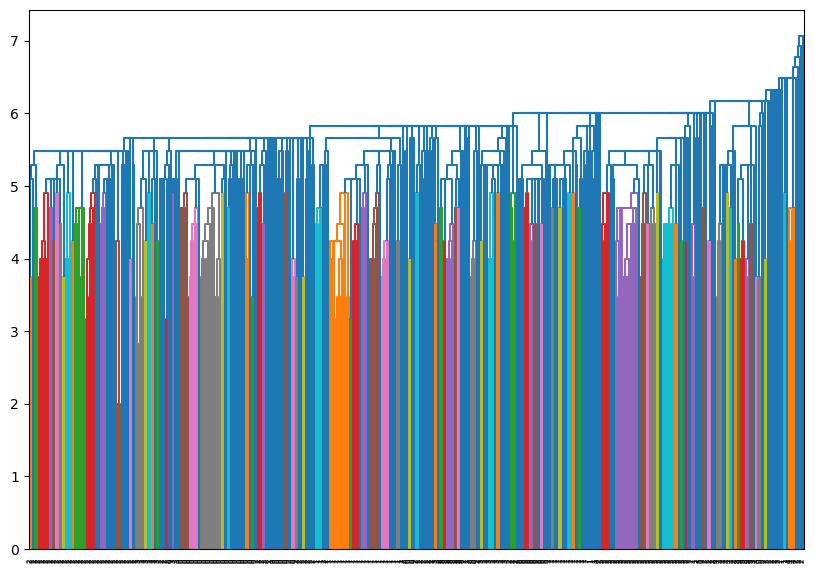

In [160]:
# визуализация дендрограммы
linked = linkage(X, 'single')
plt.figure(figsize=(10, 7))

dendrogram(linked,
            orientation='top',
            labels=agglomerative_clustering.labels_,
            distance_sort='descending',
            show_leaf_counts=True)

plt.show()

In [161]:
# Добавление предсказанных кластеров в общий датафрейм
df_matrix_text_nonnull['Сегмент'] = agglomerative_clustering.labels_
df_matrix_text_nonnull.head(2)

ВидХарактеристики,Автовзвешивание,Активатор,Бак для воды,Блокировка от детей,Вес в упаковке,Вес стиральной машины,Вид,Выбор скорости отжима,Высота,Габариты в упаковке (ШxВxГ),...,Тип,Тип загрузки,Тип управления,Управление со смартфона,Уровень шума при отжиме,Уровень шума при стирке,Функциональные особенности,Ширина,Язык панели управления,Сегмент
КодТовара,,,,,,,,,,,,,,,,,,,,,
1027919,есть,нет,нет,есть,57 кг,54 кг,автомат,есть,85 см,65x88x54 см,...,стиральная машина,фронтальная,"поворотный механизм, кнопочное",нет,76 дБ,61 дБ,самодиагностика,60 см,русский,0
1029567,нет,нет,нет,есть,64 кг,62 кг,автомат,есть,84.6 см,64.2х87.5х53.5 см,...,стиральная машина,фронтальная,"поворотный механизм, кнопочное",нет,68 дБ,59 дБ,"дозагрузка белья, самодиагностика",59.6 см,русский,6


In [162]:
# Сколько товаров в сегментах
df_matrix_text_nonnull['Сегмент'].value_counts()

2    145
0     84
1     65
5     60
3     43
7     26
4     20
6     18
8     16
9     11
Name: Сегмент, dtype: int64

## Выводы по базовой модели

Базовый метод кластеризации не дает нужного результат по ряду причин:
1) Слишком много уникальных характеристик, что сильно усложняет работу пользователя с сегментами.
2) Непонятно, на какое количество кластеров делить первый уровень, второй и третий.
3) Мы получили какие-то кластеры, но их названия в виде порядковых номеров ни о чем не говорят пользователю.
4) Невозможно интерпретировать, почему в одном кластере есть товары с различными значениями характеристик внутри одного вида характеристик.

Проблема 4 остается нерешаемой любыми базовыми методами, даже если найти решение для первых трех. Значит, нужно проявить более гибкий подход для получения жизнеспособного результата.

# 4. Нетиповое решение сегментации

Идея нового решения заключается в реализации следующей последовательности:
1. Сделать отбор нескольких наиболее подходящих видов характеристик
2. Из видов характеристик собрать наборы значений для сегментов разных уровней
3. Наборы должны иметь некоторую пластичность, чтобы сегменты получались не слишком мелкими, и не слишком крупными.

Отбор характеристик должен быть очень тщательным. С одной стороны нужны признаки, подходящие для качественной сегментации, с другой стороны конечному пользователю сегмента должно быть понятно, почему используются именно такие признаки.

## Настройка параметров

Посмотрим на основные параметры, которые есть для выбранной категории.

In [163]:
category_name = dim_category[dim_category['КодКатегории']==category]['Уровень4'].values[0]
sku = df_category.nunique()['КодТовара']
view_quantity = df_category.nunique()['КодВидаХарактеристики']
char_quantity = df_category.nunique()['КодХарактеристики']

print(f'Код категории: {category}')
print('Наименование категории: ', category_name)
print('Количество номенклатуры: ', sku)
print('Количество видов характеристик: ', view_quantity)
print('Количество значений характеристик: ', char_quantity)

Код категории: AM19415
Наименование категории:  Стиральная машина с фронтальной загрузкой
Количество номенклатуры:  488
Количество видов характеристик:  66
Количество значений характеристик:  2160


Как выяснилось выше, не по всем товарам заполняются все характеристики. Для удобства задам порог пропусков, превышение которого будет говорить о непригодности данного вида характеристик к использованию.

In [164]:
## Порог заполнения характеристик
filling_threshold = 0.7
Pass_threshold = int((1 - filling_threshold) * 100)

Если какой-то вид характеристики будет иметь единственное в основной массе значение, он будет мало ценен для кластеризации. Для исключения таких признаков задаю порог доминации для одной характеристики, выше которого вид характеристики будет исключен.

In [165]:
## Порог доминации одной характеристики
dom = 0.8 

Разные категории содержат в себе разное количество активной номенклатуры, от нескольких единиц, до нескольких тысяч. Логично предположить, что в таком случае минимальные размеры сегментов первого уровня должны быть разными. Для решения создам функцию, которая будет задавать минимальный размер кластера в зависимости от количества номенклатурных позиций в категории.

In [166]:
## Функция выбора минимального порога сегмента
def get_segment_treshhold_SKU(SKU):
    if SKU < 500:
        return 10
    elif SKU < 1000:
        return 20
    else:
        return 30

Предположу, что для нормальной грануляции сегмент первого уровня должен содержать в себе в среднем 4 сегмента второго уровня. А сегмент 3-го уровня может состоять из 2 взаимозаменяемых товаров.

In [167]:
## Сколько кластеров в сегменте (примерно)    
clusters_in_the_segment = 4

## Порог ячейки в штуках
cell_treshhold_SKU = 2

Использовать весь набор видов характеристик для сегментации может быть нецелесообразно. Лучше отобрать для этого несколько наиболее подходящих видов характеристик. Эмпирически задам для 3-го уровня максимальное количество 12 видов характеристик. Предполагаю, что в сегмент 3-го уровня должны попадать товары, у которых совпадают все 12 характеристик, то есть доля совпадений 100%. Для объединения во 2-й уровень доля совпадений должна быть 60%, для первого уровня достаточно 40%.

In [168]:
# Сколько видов характеристик оставлять
columns_count = 12

# Какие доли использовать от общего количества признаков
part_sign_segment = 0.4 # доля признаков в сегменте
part_sign_cluster = 0.6 # доля признаков в кластере
part_sign_cell = 1 # доля признаков в ячейке

Границы по признакам задаю в виде коэффициентов, а не абсолютных значений, поскольку не у всех категорий может набраться 12 видов характеристик для 3 уровня. Соответственно, характеристик на первых двух уровнях должно быть пропорционально меньше.

## Future ingenering

### Очистка от некачественных признаков

In [169]:
df = df_category # для сохранения df_category в изначальном виде

total_view = df['ВидХарактеристики'].value_counts() / sku
print(f"Всего видов характеристик: {len(total_view)}")
total_view_mod = total_view[total_view < 1.5][total_view > filling_threshold] # Убираем виды с множественным значением и плохо заполненные
print(f"Из них достаточно хорошо заполнены: {len(total_view_mod)}")
total_view_mod_list = list(total_view_mod.index)
df = df[df['ВидХарактеристики'].isin(total_view_mod_list)] # Срезаем плохо заполненные

Всего видов характеристик: 66
Из них достаточно хорошо заполнены: 48


### Создание числового признака

Поскольку уникльных значений характеристик очень много, есть идея числовые признаки объединить в диапазоны. Для этого создам числовой столбец характеристики с помощью регулярного выражения. Также какие-то категории изначально могут иметь мало видов характеристик. В таком случаи объединение в диапазоны не потребуется, отражу это в специальном условии.

In [170]:
# Условие отсутствия признаков
def get_non_number(df):
    if df.shape[0] == 0 or df.shape[1] == 0 or len(total_view_mod_list) <= columns_count:
        return True
    else: return False

# Условие пропуска этого этапа, если видов характеристик недостаточно для дальнейшей фильтрации
if get_non_number(df):
    df = df.astype(str)
    df['ЧисловоеЗначение'] = np.nan # создание пустого столбца при отсутствии числовых значений
else:
    regex = '\d*\.\d*|\d*' # регулярное выражение для нахождения чисел
    df['ЧисловоеЗначение'] = df['Характеристика'].str.findall(regex).str.get(0) # вывод столбца с числами
    df.replace('', np.nan, inplace=True)
    
df.head()

,КодТовара,ВидХарактеристики,КодВидаХарактеристики,КодХарактеристики,Характеристика,КодКатегории,Рейтинг,ЧисловоеЗначение
9284,1125285,Загрузка белья для стирки и отжима,3899,34365,7 кг,AM19415,1.0,7
42834,9953456,Загрузка белья для стирки и отжима,3899,34368,8 кг,AM19415,1.0,8
66822,1093687,Загрузка белья для стирки и отжима,3899,34366,6 кг,AM19415,1.0,6
54017,5321213,Загрузка белья для стирки и отжима,3899,34373,9 кг,AM19415,1.0,9
2963,1248798,Загрузка белья для стирки и отжима,3899,34365,7 кг,AM19415,1.0,7


### Разбивка датафрейма на два вида: с числовыми и текстовыми характеристиками

In [171]:
df_num = df[df['ЧисловоеЗначение'].notnull()].sort_values(by='Рейтинг', ascending=False)
df_text = df[df['ЧисловоеЗначение'].isna()].sort_values(by='Рейтинг', ascending=False)

display(df_num.head(2))
print()
display(df_text.head(2))

,КодТовара,ВидХарактеристики,КодВидаХарактеристики,КодХарактеристики,Характеристика,КодКатегории,Рейтинг,ЧисловоеЗначение
9284,1125285,Загрузка белья для стирки и отжима,3899,34365,7 кг,AM19415,1.0,7
45787,9909692,Загрузка белья для стирки и отжима,3899,34365,7 кг,AM19415,1.0,7


,КодТовара,ВидХарактеристики,КодВидаХарактеристики,КодХарактеристики,Характеристика,КодКатегории,Рейтинг,ЧисловоеЗначение
68806,9956588,Тип загрузки,3892,34291,фронтальная,AM19415,0.98,NaN
33205,5091382,Тип загрузки,3892,34291,фронтальная,AM19415,0.98,NaN


### Обработка числовых характеристик

In [172]:
# Проверка на чистоту заполнения числовых данных. Если будет выявлено сильное отклонение среднего от медианы, 
# то признак может содержать ошибки заполнения и его лучше исключить.

df_num['ЧисловоеЗначение'] = df_num['ЧисловоеЗначение'].astype(float) # Приводим к числовому формату
df_group = df_num.groupby('ВидХарактеристики')['ЧисловоеЗначение'].agg('describe') # Группировка для контроля отклонения среднего от медианы
df_group.sort_values(by='count', ascending=False)

print('Всего числовых признаков:', len(df_group))

df_group['Error_rate'] = df_group['mean'] / df_group['50%'] - 1 # Столбец с отклонениями медианы от среднего
deleted_signs = list(df_group[(abs(df_group['Error_rate']) >= 10) | (df_group['Error_rate'].isna()) ].index) # Список удаляемых столбцов
df_group = df_group[abs(df_group['Error_rate']) < 10] # Список оставшихся столбцов

print(f'Удалено грязных признаков: {len(deleted_signs)}')
print(deleted_signs)
print('Осталось признаков', len(df_group))
print('--------------------------')
df_num = df_num[~df_num['ВидХарактеристики'].isin(deleted_signs)]


Всего числовых признаков: 18
Удалено грязных признаков: 2
['Загрузка для сушки', 'Мощность в выключенном режиме']
Осталось признаков 16
--------------------------


In [173]:
# Заполнение матрицы числовых значений
df_matrix_num = df_num.pivot_table(
    values= 'ЧисловоеЗначение',
    index= 'КодТовара',
    columns= 'ВидХарактеристики',
    aggfunc= 'mean'
)

df_matrix_num.head(3)

ВидХарактеристики,Вес в упаковке,Вес стиральной машины,Высота,Габариты в упаковке (ШxВxГ),Глубина,Диапазон температур,Загрузка белья для стирки и отжима,Количество программ стирки,Максимальная скорость отжима,Максимальное время отсрочки запуска,Напряжение питания,Потребляемая мощность за цикл,Расход воды за стирку,Уровень шума при отжиме,Уровень шума при стирке,Ширина
КодТовара,,,,,,,,,,,,,,,,
1027919,57.0,54.0,85.0,65.0,45.0,30.0,6.0,8.0,1200.0,19.0,220.0,1.02,39.0,76.0,61.0,60.0
1029567,64.0,62.0,84.6,64.2,40.7,20.0,6.0,16.0,800.0,24.0,220.0,0.95,50.0,68.0,59.0,59.6
1030107,62.0,59.0,85.0,64.5,44.0,0.0,6.5,13.0,1200.0,19.0,220.0,1.10,56.0,76.0,55.0,60.0


In [174]:
# Вычисление доли пропущенных значений
missing_values = df_matrix_num.isna().sum() / len(df_matrix_num) * 100
missing_values_sorted = missing_values.sort_values(ascending=False).head(50)
missing_values_sorted


ВидХарактеристики
Максимальное время отсрочки запуска    18.852459
Потребляемая мощность за цикл          17.008197
Расход воды за стирку                  12.500000
Диапазон температур                    10.245902
Габариты в упаковке (ШxВxГ)             8.811475
Вес в упаковке                          7.377049
Вес стиральной машины                   3.278689
Уровень шума при отжиме                 3.073770
Уровень шума при стирке                 3.073770
Напряжение питания                      2.868852
Количество программ стирки              1.434426
Глубина                                 0.614754
Максимальная скорость отжима            0.204918
Высота                                  0.000000
Загрузка белья для стирки и отжима      0.000000
Ширина                                  0.000000
dtype: float64

In [175]:
# Столбцы превышающие порог пропусков (будут удалены)
Columns_to_delete = list(missing_values_sorted[missing_values_sorted > Pass_threshold].index) # Столбцы к удалению
df_matrix_num.drop(columns = Columns_to_delete, inplace=True)

print(f'Удалено {len(Columns_to_delete)} столбцов с большими пропусками')
print(missing_values_sorted[missing_values_sorted > Pass_threshold])

Удалено 0 столбцов с большими пропусками
Series([], dtype: float64)


In [176]:
# Заполнение пропусков 
if get_non_number(df_matrix_num): # проверка, что признаков достаточно для отбора и в таблице есть числовые признаки
    df_matrix_num_nonnull = df_matrix_num
else:
    df_matrix_num_nonnull = df_matrix_num.fillna(df_matrix_num.median().iloc[0]) # Медианой
    
# Поиск доминирующих числовых признаков
list_col = list(df_matrix_num_nonnull.columns)
list_dom = []
for view in list_col:
    if df_matrix_num_nonnull[view].value_counts(normalize=True).iloc[0] > dom:
        list_dom.append(view)     
print(f'Удалено {len(list_dom)} доминирующих числовых признаков:')
for i in list_dom:
    print(i) 
df_matrix_num_nonnull.drop(columns=list_dom, inplace=True)
print('Осталось столбцов: ', df_matrix_num_nonnull.shape[1])

Удалено 1 доминирующих числовых признаков:
Напряжение питания
Осталось столбцов:  15


### Проверка на мультиколлинеарность

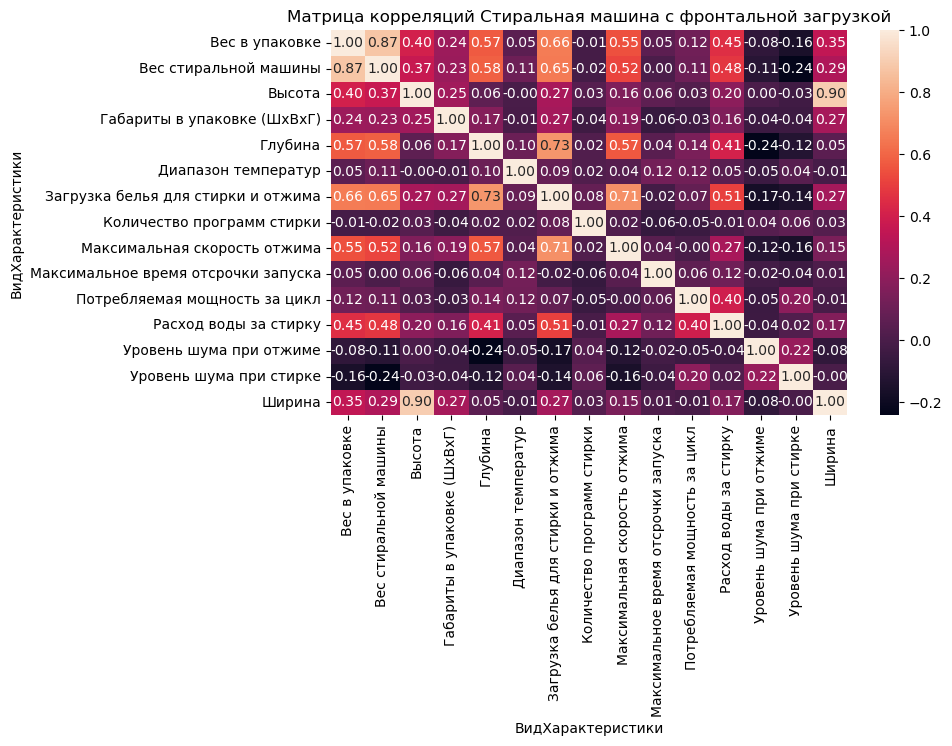

In [177]:
# Проверка на мультиколлинеарность
if get_non_number(df_matrix_num_nonnull):
    pass
else:
    collumns = df_matrix_num_nonnull.shape[1]
    df_corr = df_matrix_num_nonnull.corr()
    
    #строим график
    plt.figure(figsize=(collumns/1.8, collumns/3))
    sns.heatmap(df_corr, annot=True, fmt='.2f')
    plt.title(f'Матрица корреляций {category_name}')
    plt.show()

### Функция удаления лишних признаков

In [178]:
# Функция ищет признаки с кореляцией свыше 0.9 и составляет датафрейм из пар таких признаков.
# Далее происходет сравнение схожих признаков по рейтингу, и признак с меньшим признаком удаляется.
# Если рейтинги одинаковы, то остаются оба признака. На выходе получаем список столбцов на удаление.

def delete_columns(df_corr, dim_view, k = 0.90):
    list_1 = []
    for i in range(len(df_corr)):
        for j in range(len(df_corr)):
            if abs(df_corr.iloc[i, j]) > k and i != j:
                list_1.append([
                    df_corr.iloc[i].index[j],
                    df_corr.iloc[j].index[i] 
                    ])  
                
    # Подтягиваю значимости
    list_sign_1 = []
    list_sign_2 = []
    list_value_1 = []
    list_value_2 = []

    for view in list_1:
        sign_1 = view[0]
        sign_2 = view[1]
        value_1 = dim_view['Рейтинг'][dim_view['ВидХарактеристики'] == sign_1].iloc[0]
        value_2 = dim_view['Рейтинг'][dim_view['ВидХарактеристики'] == sign_2].iloc[0]
        
        list_sign_1.append(sign_1)
        list_sign_2.append(sign_2)
        list_value_1.append(value_1)
        list_value_2.append(value_2)

    df_sign_value = pd.DataFrame({'Вид_1': list_sign_1, 'Значимость_1' : list_value_1, 'Вид_2': list_sign_2, 'Значимость_2': list_value_2})
    # print('Количество схожих пар признаков ', len(df_sign_value))
    display(df_sign_value)
    
    # Список столбцов на удаление
    set_col_to_del = set()
    for i in range(len(df_sign_value)):
        if df_sign_value.iloc[i]['Значимость_1'] == df_sign_value.iloc[i]['Значимость_2']:
            continue
        if df_sign_value.iloc[i]['Значимость_1'] < df_sign_value.iloc[i]['Значимость_2']:
            set_col_to_del.add(df_sign_value.iloc[i]['Вид_1'])
        else:
            set_col_to_del.add(df_sign_value.iloc[i]['Вид_2'])

    list_col_to_del = list(set_col_to_del)
    print('Признаки на удаление: ', list_col_to_del)
    return list_col_to_del

### Удаление признаков с сильной корреляцией

,Вид_1,Значимость_1,Вид_2,Значимость_2
0,Ширина,1.00,Высота,0.99
1,Высота,0.99,Ширина,1.00


Признаки на удаление:  ['Высота']


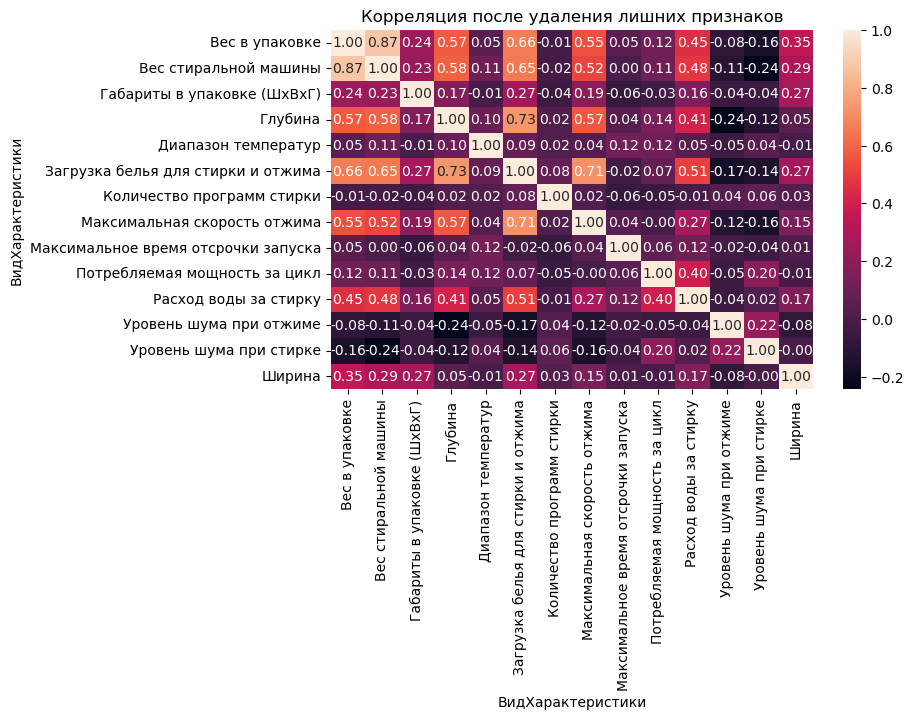

In [179]:
if get_non_number(df_matrix_num_nonnull): # Проверка на достаточное количество признаков и непустой датафрейм
    pass
else:
    col_to_del = delete_columns(df_corr, dim_view, k = 0.9)
    df_matrix_num_nonnull = df_matrix_num_nonnull.drop(columns= col_to_del)
    
    collumns = df_matrix_num_nonnull.shape[1]
    df_corr = df_matrix_num_nonnull.corr()
    
    # строим график
    plt.figure(figsize=(collumns/1.8, collumns/3))
    sns.heatmap(df_corr, annot=True, fmt='.2f')
    plt.title('Корреляция после удаления лишних признаков')
    plt.show()
    
# Если признаков недостаточно, пропускаем действие
if len(total_view_mod_list) <= 10:
    pass
else:
    df_num = df_num[df_num['ВидХарактеристики'].isin(df_matrix_num_nonnull.columns)]
    df_num['ВидХарактеристики'].value_counts()    

### Деление на числовые диапазоны

Поскольку значений характеристик очень много (в baseline получилось несколько тысяч), уменьшу их количество путем объединения в диапазоны. Диапазоны задам в соответствии с квартилями. Таким образом, получим 6 диапазонов, с учетом верхних и нижних выбросов.

In [180]:
if get_non_number(df_matrix_num_nonnull): # Проверка на достаточное количество признаков и непустой датафрейм
    pass
else:

    df_describe = df_num.merge( 
    df_group, 
    on='ВидХарактеристики', 
    how='inner' 
    )

    df_describe['размах'] = df_describe['75%'] - df_describe['25%']
    df_describe['нижние_выбросы'] = df_describe['25%'] - df_describe['размах'] * 1.5
    df_describe['нижние_выбросы'] = df_describe['нижние_выбросы'].apply(lambda x: 0 if x<0 else x)
    df_describe['премиум_сегмент'] = df_describe['75%'] + df_describe['размах'] * 1.5

    df_describe['range'] = df_describe.apply(lambda row:
        
            f"0) 0-{round(row['нижние_выбросы'], 2)}" if row['ЧисловоеЗначение'] <= row['нижние_выбросы']      
        else f"1) {round(row['нижние_выбросы'], 2)}-{round(row['25%'], 2)}" if row['ЧисловоеЗначение'] < row['25%']      
        else f"2) {round(row['25%'], 2)}-{round(row['50%'], 2)}" if row['ЧисловоеЗначение'] < row['50%']
        else f"3) {round(row['50%'], 2)}-{round(row['75%'], 2)}" if row['ЧисловоеЗначение'] < row['75%']
        else f"4) {round(row['75%'], 2)}-{round(row['премиум_сегмент'], 2)}" if row['ЧисловоеЗначение'] < row['премиум_сегмент']
        else f"5) {round(row['премиум_сегмент'], 2)}-{round(row['max'], 2)}", axis=1)

    # Присвоение диапазона каждому числовому значению.
    df_num_2 = df_describe[['КодТовара', 'ВидХарактеристики', 'ЧисловоеЗначение', 'range']]
    
# Конкатенация в один датафрейм бывших числовых и строковых данных   
if len(total_view_mod_list) <= 10 or get_non_number(df_matrix_num_nonnull) == 1:
    pass
else:
    df_text_3 = df_text[['КодТовара', 'ВидХарактеристики', 'Характеристика']]
    df_num_3 = df_num_2[['КодТовара', 'ВидХарактеристики', 'range']].rename(columns={'range':'Характеристика'})
    df_full = pd.concat([df_text_3, df_num_3])
    df_full = df_full.drop_duplicates(keep='first')
    
# Перевод на строковый тип данных    
if get_non_number(df_matrix_num_nonnull): # Проверка на достаточное количество признаков и непустой датафрейм
    df_full = df
else:
    pass
df_full = df_full.astype('str')

## Обработка текстовых характеристик

Теперь у нас единый датафрейм, состоящий только из строковых данных.

### Заполнение матрицы текстовых характеристик

In [181]:
df_matrix_text = df_full.pivot_table(
    values='Характеристика',
    index='КодТовара',
    columns='ВидХарактеристики',
    aggfunc=lambda x: ', '.join(x)
)

### Анализ и обработка пропусков

In [182]:
if len(total_view_mod_list) <= 10:
    df_matrix_text.fillna('НеЗаполнено', inplace=True)
else:
    все_пропуски_до = df_matrix_text.isna().sum().sum()
    пропуски_до = df_matrix_text.isna().sum()
    print('--------------------------')
    print('Общая сумма пропусков = ', все_пропуски_до)
    print('--------------------------')
    
missing_values = df_matrix_text.isna().sum() / len(df_matrix_text) * 100
missing_values_sorted = missing_values.sort_values(ascending=False)

# Столбцы превышающие порог пропусков (будут удалены)
Columns_to_delete = list(missing_values_sorted[missing_values_sorted > Pass_threshold].index) # Столбцы к удалению
print(f'Удалено {len(Columns_to_delete)} столбцов с высокими пропусками')
print(missing_values_sorted[missing_values_sorted > Pass_threshold])
print('--------------------------')
df_matrix_text.drop(columns = Columns_to_delete, inplace=True)   

# Заполнение пропусков (модой)
df_matrix_text_nonnull = df_matrix_text.fillna(df_matrix_text.mode().iloc[0]) # Мода
пропуски_после = df_matrix_text_nonnull.isna().sum().sum()
print('Пропусков после обработки = ', пропуски_после)
print('--------------------------')
df_text_copy = df_matrix_text_nonnull.copy()

--------------------------
Общая сумма пропусков =  1261
--------------------------
Удалено 0 столбцов с высокими пропусками
Series([], dtype: float64)
--------------------------
Пропусков после обработки =  0
--------------------------


### Поиск доминирующих характеристик

In [183]:
list_col = list(df_matrix_text_nonnull.columns)
list_dom = []
for view in list_col:
    if df_matrix_text_nonnull[view].value_counts(normalize=True)[0] > dom:
        list_dom.append(view)           
print(f'Удалено {len(list_dom)} доминирующих характеристик:')
for i in list_dom:
    print(i)       
df_matrix_text_nonnull.drop(columns=list_dom, inplace=True)
print('Осталось столбцов: ', df_matrix_text_nonnull.shape[1])
print('--------------------------')

Удалено 19 доминирующих характеристик:
Автобаланс
Активатор
Бак для воды
Блокировка от детей
Вид
Возможность установки под столешницу
Выбор скорости отжима
Голосовой помощник
Дисплей
Изменение температуры стирки
Класс стирки
Отсрочка запуска
Подсветка барабана
Прямой привод
Сторона открывания двери
Тепловой насос
Тип
Тип загрузки
Язык панели управления
Осталось столбцов:  25
--------------------------


### Обработка характеристик с высоким разбросом значений

In [184]:
sing_total = df_matrix_text_nonnull.nunique().sum()
print('Уникальные характеристики \n ', df_matrix_text_nonnull.nunique())
print('--------------------------')

if df_matrix_text_nonnull.shape[1] <= 10:
    un = sing_total * 0.3 # Порог уникальных значений
else:
    un = 50 # Порог уникальных значений
    
# Удаление видов характеристик с высоким разбросом
unic = df_matrix_text_nonnull.nunique()
unic_to_del = unic.sort_values(ascending=False).loc[unic > un]
print(f'Удалено столбцов с высоким разбросом: {len(unic_to_del)}')
print('--------------------------')
print(unic_to_del)
df_matrix_text_nonnull.drop(columns=unic_to_del.index, inplace=True)
print('Осталось столбцов: ', df_matrix_text_nonnull.shape[1])
print('Столбцы: ', df_matrix_text_nonnull.columns.values)
print('--------------------------')
df_matrix = df_matrix_text_nonnull

Уникальные характеристики 
  ВидХарактеристики
Автовзвешивание                          2
Вес в упаковке                           6
Вес стиральной машины                    6
Габариты в упаковке (ШxВxГ)              6
Глубина                                  5
Диапазон температур                      3
Дополнительный цвет                     10
Загрузка белья для стирки и отжима       6
Защита от протечек                       3
Звуковой сигнал окончания стирки         2
Инверторный двигатель                    2
Класс отжима                             5
Класс энергопотребления                  7
Количество программ стирки               6
Максимальная скорость отжима             5
Максимальное время отсрочки запуска      5
Модель                                 469
Основной цвет                            8
Потребляемая мощность за цикл            6
Приложение для управления               10
Расход воды за стирку                    6
Управление со смартфона                  6
Уровень

### Добавление вида в название характеристики

In [185]:
df_matrix_name = df_matrix.apply(lambda col: col.name + '_' + col.astype(str))
df_matrix_name.head(2)

ВидХарактеристики,Автовзвешивание,Вес в упаковке,Вес стиральной машины,Габариты в упаковке (ШxВxГ),Глубина,Диапазон температур,Дополнительный цвет,Загрузка белья для стирки и отжима,Защита от протечек,Звуковой сигнал окончания стирки,...,Максимальная скорость отжима,Максимальное время отсрочки запуска,Основной цвет,Потребляемая мощность за цикл,Приложение для управления,Расход воды за стирку,Управление со смартфона,Уровень шума при отжиме,Уровень шума при стирке,Ширина
КодТовара,,,,,,,,,,,,,,,,,,,,,
1027919,Автовзвешивание_есть,Вес в упаковке_1) 46.06-58.4,Вес стиральной машины_1) 43.7-56.0,Габариты в упаковке (ШxВxГ)_3) 65.0-66.0,Глубина_3) 44.0-50.0,Диапазон температур_4) 20.0-50.0,Дополнительный цвет_черный,Загрузка белья для стирки и отжима_2) 6.0-7.0,Защита от протечек_частичная,Звуковой сигнал окончания стирки_нет,...,Максимальная скорость отжима_3) 1200.0-1380.0,Максимальное время отсрочки запуска_0) 0-21.5,Основной цвет_белый,Потребляемая мощность за цикл_3) 0.92-1.05,Приложение для управления_нет,Расход воды за стирку_1) 33.0-45.0,Управление со смартфона_нет,Уровень шума при отжиме_3) 75.0-77.0,Уровень шума при стирке_4) 60.0-69.0,Ширина_4) 60.0-60.75
1029567,Автовзвешивание_нет,Вес в упаковке_3) 63.0-66.62,Вес стиральной машины_3) 60.5-64.2,Габариты в упаковке (ШxВxГ)_1) 62.25-64.5,Глубина_1) 28.5-41.4,Диапазон температур_4) 20.0-50.0,Дополнительный цвет_черный,Загрузка белья для стирки и отжима_2) 6.0-7.0,Защита от протечек_нет,Звуковой сигнал окончания стирки_есть,...,Максимальная скорость отжима_1) 430.0-1000.0,Максимальное время отсрочки запуска_4) 24.0-25.5,Основной цвет_белый,Потребляемая мощность за цикл_3) 0.92-1.05,Приложение для управления_нет,Расход воды за стирку_3) 48.0-53.0,Управление со смартфона_нет,Уровень шума при отжиме_0) 0-69.5,Уровень шума при стирке_3) 57.0-60.0,Ширина_2) 59.5-59.7


### Отбор признаков по приоритетности

In [186]:
# Фильтруем характеристики по выбранной категории
dim_view = dim_view[dim_view['КодКатегории'] == category] 

# Фильтруем по прошедшим все отборы признакам
dim_view_result = dim_view[dim_view['ВидХарактеристики'].isin(df_matrix_name.columns)][['ВидХарактеристики', 'Рейтинг']]

# Подготовка к визуализации
dim_view_result['Рейтинг'] = dim_view_result['Рейтинг'].astype(float)
dim_view_result['Рейтинг'] = dim_view_result['Рейтинг'].round(2)

dim_view_result = dim_view_result[['ВидХарактеристики', 'Рейтинг']].rename(columns={'ВидХарактеристики':'Вид'})
# строим график
fig = px.bar(
    data_frame=dim_view_result, #датафрейм
    x="Вид", #ось x
    y="Рейтинг", #ось y
    text = 'Рейтинг', #текст на столбцах
    orientation='v', #ориентация графика
    height=500, #высота
    width=1000, #ширина
    title='Рейтинг видов характеристик' #заголовок
)
fig.show()

# 5. Создание сегментов


In [187]:
# Минимальный порог сегмента
segment_treshhold_SKU = get_segment_treshhold_SKU(sku)
cluster_treshhold_SKU = segment_treshhold_SKU / clusters_in_the_segment
print(f' порог сегмента {segment_treshhold_SKU} \n порог кластера {cluster_treshhold_SKU} \n порог ячейки {cell_treshhold_SKU}')

columns_total = dim_view_result['Вид'].values  # Порядок столбцов по значимости

# Отсечка по количеству признаков
view_to_model = columns_total[:columns_count]
print('---------------------------------------')
print(f'Оставляем признаков {len(view_to_model)} \n{view_to_model}')
df = df_matrix_name[view_to_model]

# Сколько признаков в сегментации
count_sign_segment = int(len(df.columns) * part_sign_segment) # из скольки признаков будет состоять сегмент
count_sign_cluster = int(len(df.columns) * part_sign_cluster) # из скольки признаков будет состоять кластер
count_sign_cell = int(len(df.columns) * part_sign_cell) # из скольки признаков будет состоять ячейка
print('---------------------------------------')
print(f' Признаков в сегменте {count_sign_segment} \n Признаков в кластере {count_sign_cluster} \n Признаков в ячейке {count_sign_cell}')

# Если признаков меньше 1, то оставляем 1
if count_sign_segment < 1:
    count_sign_segment = 1
if count_sign_cluster < 1:
    count_sign_cluster = 1  
    
# Срез характеристик до сегмента, кластера, ячейки
df_segment = df.iloc[ : , : count_sign_segment]
df_cluster = df.iloc[ : , : count_sign_cluster]
df_cell = df.iloc[ : , : count_sign_cell]
segments_only = df_segment.columns  

 порог сегмента 10 
 порог кластера 2.5 
 порог ячейки 2
---------------------------------------
Оставляем признаков 12 
['Загрузка белья для стирки и отжима' 'Глубина' 'Инверторный двигатель'
 'Ширина' 'Защита от протечек' 'Основной цвет'
 'Максимальная скорость отжима' 'Класс энергопотребления'
 'Уровень шума при отжиме' 'Управление со смартфона' 'Класс отжима'
 'Звуковой сигнал окончания стирки']
---------------------------------------
 Признаков в сегменте 4 
 Признаков в кластере 7 
 Признаков в ячейке 12


## Функция постепенного снижения размерности

In [188]:
def get_treshhold(df, segment_treshhold_SKU):
    n = 0
    df['Сегмент'] = '' # Инициация столбца Сегмент
    while True: # запуск цикла
        df = df.drop(columns = 'Сегмент') # Удаление столбца (с рассчитанными слабыми сегментами)
        list_segment = [] # Инициация списка для сегментов
        for i in range(len(df)): # Проходимся по датафрейму
            cell = list(df.iloc[i].values)
            cell = ' // '.join(cell) # Соединение характеристик в одну строку
            list_segment.append(cell) # Формирование списка из получившихся сегментов
        df['Сегмент'] = list_segment # Добавление сегментов к дф
        
        # Оставляю только слабые сегменты
        s = df['Сегмент'].value_counts()
        s = s[s.values < segment_treshhold_SKU] 
        
        # Меняю последний признак на "Прочее" у слабых сегментов
        garbage = s.index
        df.loc[df['Сегмент'].isin(garbage), df.columns[-2-n]] = 'Прочее'
        
        df = df.drop(columns = 'Сегмент')
        # Создаем или обновляем столбец с названием сегмента
        # Новые сегменты создаются с учетом того, что в слабых сегментах последний признак 
        # заменен на "Прочее".
        list_segment = []
        for i in range(len(df)):
            cell = list(df.iloc[i].values)
            cell = ' // '.join(cell)
            list_segment.append(cell)
        df['Сегмент'] = list_segment   
    
        n = n+1
        # Остановка если весь товар распределен по сегментам достаточной силы
        if len(s) == 0:
            break 
        # Остановка если все признаки прошли замену на "Прочее"
        if n == df.shape[1]-1:
            break
        # Защита от бесконечного цикла, если что-то пойдет не так
        if n == 100:
            break
    return df

## Применяем функцию для создания уровней сегментации

In [189]:
s_segment = get_treshhold(df_segment, segment_treshhold_SKU)['Сегмент']
s_cluster = get_treshhold(df_cluster, cluster_treshhold_SKU)['Сегмент']
s_cell = get_treshhold(df_cell, cell_treshhold_SKU)['Сегмент']

print('всего сегментов', len(s_segment.value_counts()))
print('всего кластеров', len(s_cluster.value_counts()))
print('всего ячеек', len(s_cell.value_counts()))
print('всего номенклатуры', sku)

всего сегментов 27
всего кластеров 109
всего ячеек 218
всего номенклатуры 488


### Объединение в одну таблицу

In [190]:

df_full = pd.concat([s_segment, s_cluster, s_cell], axis=1, keys=['Сегмент', 'Кластер', 'Ячейка'])
# Удаляем из названий лишние "прочие"
df_full = df_full.apply(lambda x: x.str.rstrip('// Прочее') if any(isinstance(cell, str) and cell.endswith('// Прочее') for cell in x) else x) 
df_full = df_full.replace('', 'Прочее') # Если не нужен сегмент "Прочее", заменить на np.nan

df_full = df_full.rename(columns={'Сегмент':'Уровень_1', 'Кластер':'Уровень_2', 'Ячейка':'Уровень_3'})
df_full_copy = df_full.reset_index()
df_full_copy.head(2)

,КодТовара,Уровень_1,Уровень_2,Уровень_3
0,1027919,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...
1,1029567,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...


In [191]:
# Соединяю виды и характеристики в исходном датафрейме
df_0_new = df_0[df_0['ВидХарактеристики'].isin(view_to_model)]
df_0_new['Вид_Значение'] = df_0_new['ВидХарактеристики'] + '_' + df_0_new['Характеристика'] 
df_0_new = df_0_new.astype('str')
df_0_new = df_0_new.rename(columns={'Код': 'КодТовара'})
df_0_new.info()
df_0_new.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9731 entries, 5 to 82947
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   КодТовара              9731 non-null   object
 1   ВидХарактеристики      9731 non-null   object
 2   КодВидаХарактеристики  9731 non-null   object
 3   КодХарактеристики      9731 non-null   object
 4   Характеристика         9731 non-null   object
 5   Значимость             9731 non-null   object
 6   Вид_Значение           9731 non-null   object
dtypes: object(7)
memory usage: 608.2+ KB


,КодТовара,ВидХарактеристики,КодВидаХарактеристики,КодХарактеристики,Характеристика,Значимость,Вид_Значение
5,5334213,Основной цвет,13486,163232,белый,200,Основной цвет_белый
43,5334213,Управление со смартфона,1176356,57431681,нет,190,Управление со смартфона_нет


In [192]:
df_0_new_join = df_0_new.groupby('КодТовара')['Вид_Значение'].apply(', '.join)
df_0_new_join.head(3)

КодТовара
1019743    Глубина_39 см, Звуковой сигнал окончания стирк...
1021151    Глубина_33 см, Звуковой сигнал окончания стирк...
1021995    Основной цвет_белый, Управление со смартфона_н...
Name: Вид_Значение, dtype: object

In [193]:
# Группирую по коду, новый столбец в виде списка
df_0_new_join = df_0_new.groupby('КодТовара')['Вид_Значение'].apply(', '.join)
df_0_new_join_code = df_0_new.groupby('КодТовара')['КодХарактеристики'].apply(', '.join)
df_0_new_join_code.head(3)

КодТовара
1019743    50680753, 50681971, 50682026, 50682034, 506819...
1021151    50680738, 50681972, 50682043, 50681990, 506804...
1021995    163232, 57431681, 163437, 163446, 64194778, 16...
Name: КодХарактеристики, dtype: object

In [194]:
# Присоединяю полученный список к итоговому дф
df_full_join = pd.merge(df_full, df_0_new_join, on='КодТовара')
df_full_join = pd.merge(df_full_join, df_0_new_join_code, on='КодТовара')
df_full_join.head(3)

,Уровень_1,Уровень_2,Уровень_3,Вид_Значение,КодХарактеристики
КодТовара,,,,,
1027919,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"Максимальная скорость отжима_1200 об/мин, Осно...","34390, 123304, 56836560, 34471, 127332, 127407..."
1029567,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"Глубина_40.7 см, Загрузка белья для стирки и о...","425616, 34366, 34403, 34432, 686399, 34361, 34..."
1030107,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"Управление со смартфона_нет, Уровень шума при ...","56836560, 34471, 127332, 127386, 34379, 34403,..."


### Функции преобразований типов двнных в датафрейме

In [195]:
# определяем функцию для преобразования строки в множество
def string_to_set(string):
    return set(string.split(', '))

# определяем функцию для преобразования множества в строку
def set_to_list(set):
    return sorted(list(set))

# определяем функцию для преобразования множества в строку
def set_to_string(set):
    return str(set)

# функция группировки и преобразования в наборы
def get_selection(df, lvl, collumn, new_name):
    df = df.groupby(lvl)[collumn].apply(', '.join).reset_index()
    df[collumn] = df[collumn].apply(string_to_set)
    df[collumn] = df[collumn].apply(set_to_string)
    df = df.rename(columns={collumn: new_name})
    return df

In [196]:
lvl_1_selection_view = get_selection(df_full_join, 'Уровень_1', 'Вид_Значение', 'Наборы_Ур_1')
lvl_1_selection_code = get_selection(df_full_join, 'Уровень_1', 'КодХарактеристики', 'Наборы_Ур_1_коды')
display(lvl_1_selection_view.head(2))

lvl_2_selection_view = get_selection(df_full_join, ['Уровень_1','Уровень_2'], 'Вид_Значение', 'Наборы_Ур_2')
lvl_2_selection_code = get_selection(df_full_join, ['Уровень_1','Уровень_2'], 'КодХарактеристики', 'Наборы_Ур_2_коды')
display(lvl_2_selection_code.head(2))

lvl_3_selection_view = get_selection(df_full_join, ['Уровень_1','Уровень_2','Уровень_3'], 'Вид_Значение', 'Наборы_Ур_3')
lvl_3_selection_code = get_selection(df_full_join, ['Уровень_1','Уровень_2','Уровень_3'], 'КодХарактеристики', 'Наборы_Ур_3_коды')
display(lvl_3_selection_code.head(2))

,Уровень_1,Наборы_Ур_1
0,Загрузка белья для стирки и отжима_1) 3.0-6.0,"{'Ширина_51 см', 'Звуковой сигнал окончания ст..."
1,Загрузка белья для стирки и отжима_1) 3.0-6.0 ...,"{'Уровень шума при отжиме_77 дБ', 'Глубина_33 ..."


,Уровень_1,Уровень_2,Наборы_Ур_2_коды
0,Загрузка белья для стирки и отжима_1) 3.0-6.0,Загрузка белья для стирки и отжима_1) 3.0-6.0,"{'127391', '34387', '34403', '122408054', '673..."
1,Загрузка белья для стирки и отжима_1) 3.0-6.0,Загрузка белья для стирки и отжима_1) 3.0-6.0 ...,"{'34471', '34467', '34362', '127386', '1370605..."


,Уровень_1,Уровень_2,Уровень_3,Наборы_Ур_3_коды
0,Загрузка белья для стирки и отжима_1) 3.0-6.0,Загрузка белья для стирки и отжима_1) 3.0-6.0,Загрузка белья для стирки и отжима_1) 3.0-6.0 ...,"{'127391', '34387', '34403', '122408054', '673..."
1,Загрузка белья для стирки и отжима_1) 3.0-6.0,Загрузка белья для стирки и отжима_1) 3.0-6.0 ...,Загрузка белья для стирки и отжима_1) 3.0-6.0 ...,"{'34387', '34403', '673143', '56836560', '3446..."


По наборам в дальнейшем будет происходить классификация нового товара, который сейчас не участвует в формировании сегментов.

## Выгрузка модели

In [197]:
# # Добавляю столбцы наборов в общий дф
df_full = pd.merge(df_full_copy.dropna(how='any'), lvl_1_selection_view, on='Уровень_1')
df_full = pd.merge(df_full, lvl_1_selection_code, on='Уровень_1')
df_full = pd.merge(df_full, lvl_2_selection_view, on=['Уровень_1', 'Уровень_2'])
df_full = pd.merge(df_full, lvl_2_selection_code, on=['Уровень_1', 'Уровень_2'])
df_full = pd.merge(df_full, lvl_3_selection_view, on=['Уровень_1', 'Уровень_2','Уровень_3'])
df_full = pd.merge(df_full, lvl_3_selection_code, on=['Уровень_1', 'Уровень_2','Уровень_3'])   
df_full = df_full.set_index('КодТовара')
df_full.head(3)

,Уровень_1,Уровень_2,Уровень_3,Наборы_Ур_1,Наборы_Ур_1_коды,Наборы_Ур_2,Наборы_Ур_2_коды,Наборы_Ур_3,Наборы_Ур_3_коды
КодТовара,,,,,,,,,
1027919,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'34471', '34467', '34390', '34362', '68367428...","{'Звуковой сигнал окончания стирки_нет', 'Звук...","{'34471', '34390', '34362', '34405', '123304',...","{'Класс энергопотребления_A', 'Защита от проте...","{'34431', '34405', '34471', '123304', '34390',..."
9031756,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'34471', '34467', '34390', '34362', '68367428...","{'Звуковой сигнал окончания стирки_нет', 'Звук...","{'34471', '34390', '34362', '34405', '123304',...","{'Уровень шума при отжиме_78 дБ', 'Защита от п...","{'34469', '34387', '34389', '34225', '123304',..."
9958884,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'34471', '34467', '34390', '34362', '68367428...","{'Звуковой сигнал окончания стирки_нет', 'Звук...","{'34471', '34390', '34362', '34405', '123304',...","{'Уровень шума при отжиме_78 дБ', 'Защита от п...","{'34469', '34387', '34389', '34225', '123304',..."


In [198]:
# Модель сегментации готова!
# Её можно выгрузить в Excel для ознакомления с ней заказчика. Например, можно сформировать сводную
# таблицу с иерархией сегментов, и посмотреть, какой товар туда вошел
with pd.ExcelWriter(f"data/Тестовая_модель_по_{category_name}.xlsx") as writer:
    df_full.to_excel(writer, sheet_name="Sheet1")

# 6. Блок настройки данных для последующей классификации нового товара.

In [199]:
# Оставляем сегменты без товара
df_for_import = df_full.dropna(how='any')
df_for_import = df_for_import[['Уровень_1', 'Уровень_2', 'Уровень_3', 'Наборы_Ур_1', 'Наборы_Ур_2', 'Наборы_Ур_3', 'Наборы_Ур_1_коды', 'Наборы_Ур_2_коды', 'Наборы_Ур_3_коды']]
df_for_import = df_for_import.drop_duplicates(subset = ['Уровень_1', 'Уровень_2', 'Уровень_3']).reset_index(drop=True)
df_for_import.head(3)


,Уровень_1,Уровень_2,Уровень_3,Наборы_Ур_1,Наборы_Ур_2,Наборы_Ур_3,Наборы_Ур_1_коды,Наборы_Ур_2_коды,Наборы_Ур_3_коды
0,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'Звуковой сигнал окончания стирки_нет', 'Звук...","{'Класс энергопотребления_A', 'Защита от проте...","{'34471', '34467', '34390', '34362', '68367428...","{'34471', '34390', '34362', '34405', '123304',...","{'34431', '34405', '34471', '123304', '34390',..."
1,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'Звуковой сигнал окончания стирки_нет', 'Звук...","{'Уровень шума при отжиме_78 дБ', 'Защита от п...","{'34471', '34467', '34390', '34362', '68367428...","{'34471', '34390', '34362', '34405', '123304',...","{'34469', '34387', '34389', '34225', '123304',..."
2,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'34471', '34467', '34390', '34362', '68367428...","{'34471', '34467', '34362', '127386', '127334'...","{'34471', '34467', '34362', '127386', '127334'..."


In [200]:
# Разделение по уровням с удалением дубликатов
df_code_collumns_lvl_1 = df_for_import[['Уровень_1', 'Наборы_Ур_1', 'Наборы_Ур_1_коды']].drop_duplicates()
df_code_collumns_lvl_1['НомерУровня'] = 1
df_code_collumns_lvl_2 = df_for_import[['Уровень_1', 'Наборы_Ур_1', 'Наборы_Ур_1_коды', 'Уровень_2', 'Наборы_Ур_2', 'Наборы_Ур_2_коды']].drop_duplicates()
df_code_collumns_lvl_2['НомерУровня'] = 2
df_code_collumns_lvl_3 = df_for_import.drop_duplicates()
df_code_collumns_lvl_3['НомерУровня'] = 3

### Сборка в новую структуру

In [201]:
df_code_collumns_lvl_1 = df_code_collumns_lvl_1.rename(columns={'Уровень_1': 'Сегмент', 'Наборы_Ур_1': 'Характеристики', 'Наборы_Ур_1_коды': 'КодыХарактеристик'})
df_code_collumns_lvl_2 = df_code_collumns_lvl_2.drop(columns=['Уровень_1', 'Наборы_Ур_1', 'Наборы_Ур_1_коды']).rename(
    columns={'Уровень_2': 'Сегмент', 'Наборы_Ур_2': 'Характеристики', 'Наборы_Ур_2_коды': 'КодыХарактеристик'})
df_code_collumns_lvl_3 = df_code_collumns_lvl_3[['Уровень_3', 'Наборы_Ур_3', 'Наборы_Ур_3_коды', 'НомерУровня']].rename(
    columns={'Уровень_3': 'Сегмент', 'Наборы_Ур_3': 'Характеристики', 'Наборы_Ур_3_коды': 'КодыХарактеристик'})

df_code_collumns_import = pd.concat(
    [df_code_collumns_lvl_1, df_code_collumns_lvl_2, df_code_collumns_lvl_3],
    ignore_index=True
    )
df_code_collumns_import = df_code_collumns_import.drop_duplicates(ignore_index=True)
df_code_collumns_import.head(3)

,Сегмент,Характеристики,КодыХарактеристик,НомерУровня
0,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'34471', '34467', '34390', '34362', '68367428...",1
1,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_41 см', 'Уровень шума при отжиме_79 ...","{'439245', '34471', '34390', '34362', '34361',...",1
2,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Звуковой сигнал окончания стирки_есть', 'Глу...","{'34471', '34467', '56714897', '34390', '34362...",1


In [202]:
# Определение силы (плотности) сегмента.
# Плотность сегмента определяется количеством характеристик, из которых он состоит. Чем больше характеристик, тем плотнее сегмент.
df_code_collumns_import['Power'] = df_code_collumns_import['Сегмент'].apply(lambda x: (len(x) - len(x.replace('//', ''))) / 2 +1)
df_code_collumns_import.head(2)

,Сегмент,Характеристики,КодыХарактеристик,НомерУровня,Power
0,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'34471', '34467', '34390', '34362', '68367428...",1,3.0
1,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_41 см', 'Уровень шума при отжиме_79 ...","{'439245', '34471', '34390', '34362', '34361',...",1,4.0


In [203]:
# Деление на фреймы по уровням сегмента
df_lwl1 = df_code_collumns_import[df_code_collumns_import['НомерУровня'] == 1]
df_lwl2 = df_code_collumns_import[df_code_collumns_import['НомерУровня'] == 2]
df_lwl3 = df_code_collumns_import[df_code_collumns_import['НомерУровня'] == 3]
# максимальная сила внутри уровня сегмента
max_power_1 = df_lwl1['Power'].max()
max_power_2 = df_lwl2['Power'].max()
max_power_3 = df_lwl3['Power'].max()

# Выявить и удалить слабые сегменты. Те что слабее чем предыдущий уровень. И обеспечить уникальность наименований.
df_lwl1['Сегмент'] = df_lwl1['Сегмент'].apply(lambda x: category_name + ' // ' + 'Прочее' if x=='Прочее' else x)

df_lwl2['Power'] = df_lwl2['Power'].apply(lambda x: np.nan if x<max_power_1 else x)
df_lwl2['Сегмент'] = df_lwl2.apply(lambda row: row['Сегмент'] + ' // Прочее' if row['Power']==max_power_1 else row['Сегмент'], axis=1)
df_lwl2 = df_lwl2.dropna()

df_lwl3['Power'] = df_lwl3['Power'].apply(lambda x: np.nan if x<max_power_2 else x)
df_lwl3['Сегмент'] = df_lwl3.apply(lambda row: row['Сегмент'] + ' // Прочее' if row['Power']==max_power_2 else row['Сегмент'], axis=1)
df_lwl3 = df_lwl3.dropna()

# мини справочники подчиненности
df_for_cluster = df_for_import[['Уровень_1', 'Уровень_2']].drop_duplicates()
df_for_cells = df_for_import[['Уровень_2', 'Уровень_3']].drop_duplicates()

# Объединение в форму для импорта. Добавление родительского столбца.
df_lwl1['Родитель'] = np.nan
df_merge_lvl_2 = df_lwl2.merge(df_for_cluster, left_on='Сегмент', right_on='Уровень_2', how='inner').drop(columns='Уровень_2').rename(columns={'Уровень_1': 'Родитель'})
df_merge_lvl_3 = df_lwl3.merge(df_for_cells, left_on='Сегмент', right_on='Уровень_3', how='inner').drop(columns='Уровень_3').rename(columns={'Уровень_2': 'Родитель'})

df_code_collumns_import_v2 = pd.concat([df_lwl1, df_merge_lvl_2, df_merge_lvl_3], axis=0, ignore_index=True)
df_code_collumns_import_v2.head()

,Сегмент,Характеристики,КодыХарактеристик,НомерУровня,Power,Родитель
0,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_46 см', 'Звуковой сигнал окончания с...","{'34471', '34467', '34390', '34362', '68367428...",1,3.0,NaN
1,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Глубина_41 см', 'Уровень шума при отжиме_79 ...","{'439245', '34471', '34390', '34362', '34361',...",1,4.0,NaN
2,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Звуковой сигнал окончания стирки_есть', 'Глу...","{'34471', '34467', '56714897', '34390', '34362...",1,4.0,NaN
3,Загрузка белья для стирки и отжима_2) 6.0-7.0 ...,"{'Уровень шума при отжиме_79 дБ', 'Звуковой си...","{'439245', '34471', '34390', '34362', '34481',...",1,4.0,NaN
4,Загрузка белья для стирки и отжима_1) 3.0-6.0 ...,"{'Уровень шума при отжиме_77 дБ', 'Глубина_33 ...","{'56714895', '34471', '56714897', '34467', '34...",1,3.0,NaN


In [204]:
 ###### Запись данных для импорта #######

# with pd.ExcelWriter(f"data/Сегменты по категории {category_name}.xlsx") as writer:
#     df_code_collumns_import_v2.to_excel(writer, sheet_name="ДляИмпорта", index=False)
    
print(f"Сегменты по категории {category_name} записаны")

Сегменты по категории Стиральная машина с фронтальной загрузкой записаны


# 7. Итоги

В данном коде на примере одной категории построена модель данных для сегментации товара на три уровня. Для того чтобы получить сегментацию по всем категориям, на следующем этапе преобразую данный код в скрипт и запущу в цикле по всем категориям.
Также подготовлены выходные данные в виде справочника сегментов, обогащенного показателем плотности и родительским столбцом. С помощью этого справочника на следующем этапе будет производиться классификация всего товара, в том числе отсутствующего сейчас на остатках (не участвовавшего в построении модели).